In [291]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [368]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 1             # 추출할 주파수 개수
design_region_resolution = 50

In [369]:
tag_bot         = 0.5
tag_side        = 4
tsio2           = 4
tdesignregion   = 1
monitor_position =  1 / fcen * 2
monitor_blank   = 1 / fcen * 0.1

tpml = 0.4

width_ag = 0.2
width_sio2 = 2

width_bot_ag = width_ag+width_sio2+width_ag

design_region_width = round(width_bot_ag, 3)
design_region_height = 1

Sx = tpml+width_bot_ag+tpml
Sy = round(tag_bot+tag_side+tdesignregion+monitor_position+monitor_blank+tpml)

SiO2 = mp.Medium(index = 1.45)
TiO2 = mp.Medium(index = 2.6)

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

y_bottom = -Sy/2
center_y_ag = y_bottom + tag_bot / 2
center_y_sio2 = y_bottom + tag_bot + tsio2 / 2
center_y_design = y_bottom + tag_bot + tsio2 + design_region_height / 2
center_y_monitor_position = y_bottom + tag_bot + tsio2 + design_region_height + monitor_position
center_y_source_position = y_bottom + tag_bot + 1/fcen 
center_Ag_x_position = design_region_width/2-width_ag/2 #+ tpml/2

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), TiO2, SiO2,  grid_type="U_MEAN")

design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0, center_y_design, 0),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)


boundary_layers = [mp.Absorber(tpml,direction=mp.X),
                   mp.PML(tpml,direction=mp.Y,side=mp.High)]

In [370]:
cell_size = mp.Vector3(Sx, Sy)
geometry = [
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    mp.Block(
        material=design_variables,
        size=mp.Vector3(design_region_width, design_region_height, 0),
        center=mp.Vector3(0, center_y_design, 0)
    ),

    ######### Side metal ########## 
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]

In [371]:
src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)

sources = mp.Source(
            src,
            component=mp.Ez,
            center=mp.Vector3(
                0,
                center_y_source_position,  # Alq3 층의 중간 높이
                0
            )
        )

sim = mp.Simulation(
    resolution=resolution,
    sources=[sources],
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry,
    default_material=mp.Medium(index = 1),
    extra_materials=[Ag]
)

In [372]:
minimum_length = 0.09  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

def mapping(x, eta, beta):

    return x

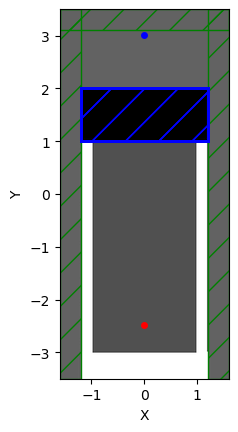

In [373]:
monitor_position_J, monitor_size = mp.Vector3(0, center_y_monitor_position), mp.Vector3(0,0)
FourierFields = mpa.FourierFields(sim,mp.Volume(center=monitor_position_J,size=monitor_size),mp.Ez,yee_grid=True)
ob_list = [FourierFields]

def J(fields):
    return npa.mean(npa.abs(fields) ** 2) # The index 1 corresponds to the point at the center of our monitor.

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=[fcen],
    maximum_run_time=100,
)

opt.plot2D(True)

In [347]:
class AdamOptimizer:
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, warmup_iters=10):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mt = None
        self.vt = None
        self.iter = 0
        self.warmup_iters = warmup_iters
    
    def update(self, v, gradient):
        if self.mt is None:
            self.mt = np.zeros_like(v)
        if self.vt is None:
            self.vt = np.zeros_like(v)
            
        #Adam에서는 기울기 값과 기울기의 제곱값의 지수이동평균을 활용하여 step 변회량을 조절
        self.iter += 1
        self.mt = self.beta1 * self.mt + (1 - self.beta1) * gradient           #m_(t)=beta_(1)*m_(t-1)+(1-beta_(1))*gradient
        self.vt = self.beta2 * self.vt + (1 - self.beta2) * (gradient ** 2)       #v_(t)=beta_(2)*v_(t-1)+(1-beta_(2))*(gradeint^2)
        
        # 초기 몇번의 update에서 0으로 편향되어 있어서 출발 지점에서 멀리 떨어진 곳으로 이동하는, 초기 경로의 편향 문제를 해결 하기 위해 unbiased하게 만들어줌
        m_hat = self.mt / (1 - self.beta1 ** self.iter)   #m_hat=m/(1-beta1**t)
        v_hat = self.vt / (1 - self.beta2 ** self.iter)
        
        # Warm-up 단계
        if self.iter <= self.warmup_iters:
            warmup_factor = self.iter / self.warmup_iters
            lr = self.lr * warmup_factor
        else:
            lr = self.lr   #lr_t <- alpha*sqrt
            
        #update = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        update_factor= m_hat / (np.sqrt(v_hat) + self.epsilon) #theta_t <- theta_(t-1)-alpha_(t)*m_(t)/(sqrt(v_(t))+epsilon) alpha_(t)=learning rate
        update = lr * update_factor
        updated_v = v + update
        updated_v = np.clip(updated_v, 0.0, 1.0)
        
        adam_lr=np.mean(np.abs(update))
        adam_uf=np.mean(np.abs(update_factor))
        
        # adam_beta1=self.beta1
        # # adam_beta2=self.beta2
        adam_m=self.mt
        adam_v=self.vt
        adam_t=self.iter
        
        return updated_v, adam_lr, adam_uf, adam_m, adam_v, adam_t

In [352]:
eta_i = 0.5

def mapping(x, beta, eta_i):
    projected_field = mpa.tanh_projection(x, beta, eta_i)

    # left-right symmetry
    projected_field = (
        npa.flipud(projected_field) + projected_field
    ) / 2

    return projected_field.flatten()

In [353]:
cur_iter = [0]
binary_history = []
evaluation_history = []
binarization_history = []
beta_history = []

full_center_y = y_bottom + tag_bot + tsio2 + design_region_height/2

optimizer = AdamOptimizer(lr=0.02, beta1=0.9)

def f (v, gradient, beta):
    # binarization_degree = np.sum(np.abs(v-0.5))*2 / (v.size)
    binarization_degree = np.sum(np.abs(v-0.5)) / (0.5 * v.size)
    binarization_history.append(binarization_degree)

    print("Current iteration: {}".format(cur_iter[0] + 1))

    rho_vector = mapping(v, beta, eta_i)

    f0, dJ_du = opt([rho_vector])

    f = np.array([np.real(f0)])

    if v.size > 0:
        
        # dJ = np.sum(dJ_du[0])
        gradient = tensor_jacobian_product(mapping,0)(
            v, beta, eta_i, dJ_du
        )

        updated_x, adam_lr, adam_uf, adam_m, adam_v, adam_t = optimizer.update(v, gradient)

        beta= beta+ npa.tanh((beta-0.5)*0.01)

        # beta_multiplier = 1.005  # 1 + 0.5%

        # beta = beta * beta_multiplier

        evaluation_history.append(f)
        beta_history.append(beta)
        cur_iter[0] = cur_iter[0] + 1
        # lr_history.append(adam_lr)
        # uf_history.append(adam_uf)
        # t_history.append(adam_t
    # print('f=', f, 'dJ=',dJ_du)

        print("Current beta: {}".format(beta))
        print("Current FOM: {}".format(f))
        print(f"→ Binary degree = {binarization_history[cur_iter[0]-1]:.3f}")

    ###########################################
    plt.figure(figsize = (3,2))
    ax = plt.gca()
    opt.plot2D(
        False,

        output_plane = mp.Volume(size = mp.Vector3(2.4, 1, 0), center = mp.Vector3(0, full_center_y,0)),
        ax=ax,
        show_sources=False,
        show_monitors=False,
        show_boundary_layers=False,
    )

    ax.axis("off")
    plt.show()
    ###########################################
    
    
    return updated_x, adam_m, adam_v, beta

In [354]:
mp.verbosity(0)

0

Current iteration: 1
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 5.0449696495836
Current FOM: [0.00086994]
→ Binary degree = 0.000


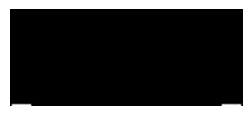

Current iteration: 2
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 5.0903880771498295
Current FOM: [0.00106246]
→ Binary degree = 0.004


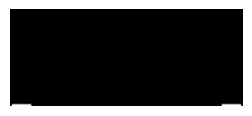

Current iteration: 3
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 5.136259742704444
Current FOM: [0.00133164]
→ Binary degree = 0.011


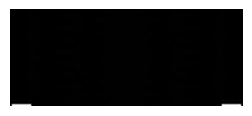

Current iteration: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 5.182589150014614
Current FOM: [0.00165509]
→ Binary degree = 0.020


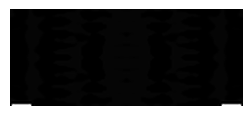

Current iteration: 5
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 5.229380847021284
Current FOM: [0.00214125]
→ Binary degree = 0.030


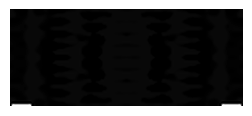

Current iteration: 6
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 5.276639426254883
Current FOM: [0.00274451]
→ Binary degree = 0.042


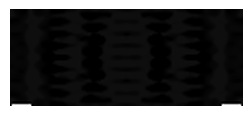

Current iteration: 7
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 5.324369525254424
Current FOM: [0.00350168]
→ Binary degree = 0.056


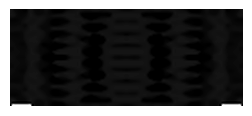

Current iteration: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 5.372575826989981
Current FOM: [0.00530824]
→ Binary degree = 0.071


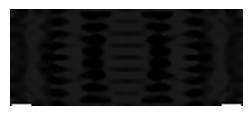

Current iteration: 9
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 5.421263060288572
Current FOM: [0.00570109]
→ Binary degree = 0.086


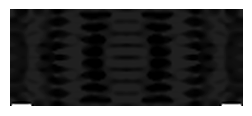

Current iteration: 10
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 5.470436000263446
Current FOM: [0.00778333]
→ Binary degree = 0.097


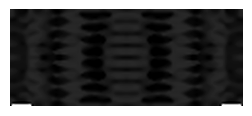

Current iteration: 11
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 5.520099468746777
Current FOM: [0.01064843]
→ Binary degree = 0.106


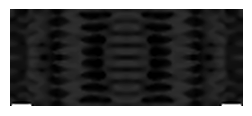

Current iteration: 12
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 5.570258334725795
Current FOM: [0.01050441]
→ Binary degree = 0.115


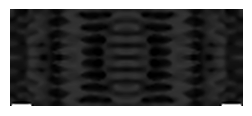

Current iteration: 13
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 5.620917514782337
Current FOM: [0.01002882]
→ Binary degree = 0.123


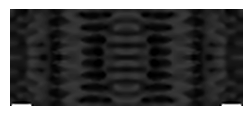

Current iteration: 14
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 5.6720819735358425
Current FOM: [0.01258932]
→ Binary degree = 0.127


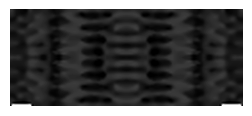

Current iteration: 15
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 5.723756724089784
Current FOM: [0.01370613]
→ Binary degree = 0.133


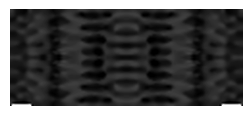

Current iteration: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 5.775946828481556
Current FOM: [0.01471754]
→ Binary degree = 0.140


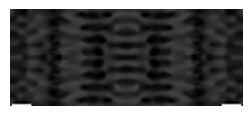

Current iteration: 17
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 5.828657398135806
Current FOM: [0.01509058]
→ Binary degree = 0.146


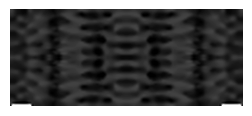

Current iteration: 18
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 5.881893594321233
Current FOM: [0.01689586]
→ Binary degree = 0.151


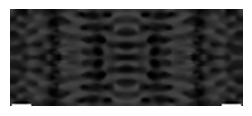

Current iteration: 19
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 5.935660628610834
Current FOM: [0.01677194]
→ Binary degree = 0.157


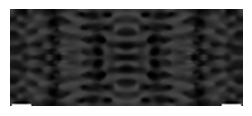

Current iteration: 20
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 5.98996376334562
Current FOM: [0.01643212]
→ Binary degree = 0.162


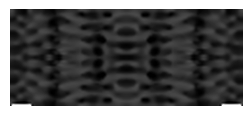

Current iteration: 21
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 6.044808312101786
Current FOM: [0.01772493]
→ Binary degree = 0.168


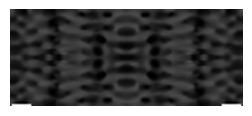

Current iteration: 22
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 6.100199640161349
Current FOM: [0.01924894]
→ Binary degree = 0.174


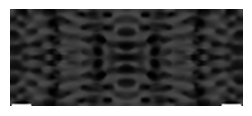

Current iteration: 23
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 6.156143164986237
Current FOM: [0.01936089]
→ Binary degree = 0.180


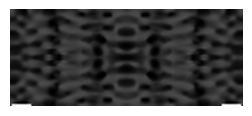

Current iteration: 24
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 6.212644356695848
Current FOM: [0.01901157]
→ Binary degree = 0.187


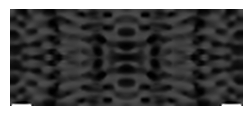

Current iteration: 25
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 6.269708738548049
Current FOM: [0.02082725]
→ Binary degree = 0.194


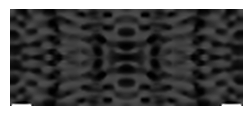

Current iteration: 26
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 6.3273418874236365
Current FOM: [0.02114778]
→ Binary degree = 0.201


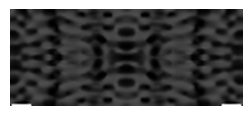

Current iteration: 27
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 6.3855494343142345
Current FOM: [0.02107723]
→ Binary degree = 0.207


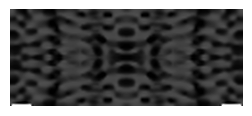

Current iteration: 28
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 6.444337064813632
Current FOM: [0.02178463]
→ Binary degree = 0.213


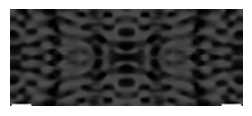

Current iteration: 29
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 6.5037105196125475
Current FOM: [0.02071819]
→ Binary degree = 0.220


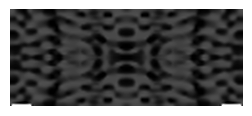

Current iteration: 30
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 6.563675594996817
Current FOM: [0.0206244]
→ Binary degree = 0.225


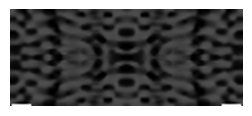

Current iteration: 31
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 6.624238143348985
Current FOM: [0.0215648]
→ Binary degree = 0.230


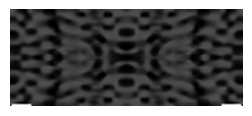

Current iteration: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 6.685404073653296
Current FOM: [0.02152494]
→ Binary degree = 0.235


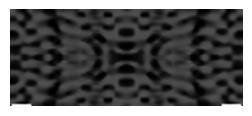

Current iteration: 33
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 6.747179352004066
Current FOM: [0.02199372]
→ Binary degree = 0.239


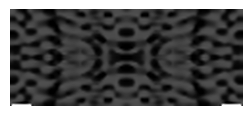

Current iteration: 34
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 6.809570002117424
Current FOM: [0.02238227]
→ Binary degree = 0.244


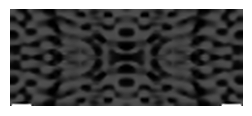

Current iteration: 35
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 6.872582105846402
Current FOM: [0.02170711]
→ Binary degree = 0.248


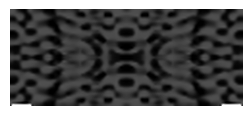

Current iteration: 36
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 6.936221803699357
Current FOM: [0.02234426]
→ Binary degree = 0.253


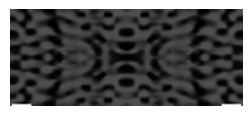

Current iteration: 37
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 7.000495295361704
Current FOM: [0.02280426]
→ Binary degree = 0.257


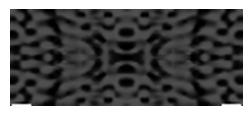

Current iteration: 38
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 7.065408840220945
Current FOM: [0.02153736]
→ Binary degree = 0.261


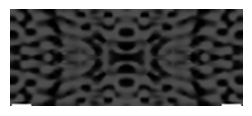

Current iteration: 39
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 7.130968757894958
Current FOM: [0.02179006]
→ Binary degree = 0.266


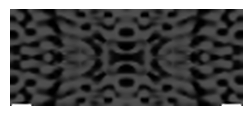

Current iteration: 40
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 7.197181428763526
Current FOM: [0.02211337]
→ Binary degree = 0.270


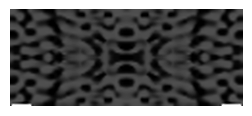

Current iteration: 41
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 7.264053294503088
Current FOM: [0.01982851]
→ Binary degree = 0.275


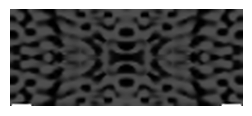

Current iteration: 42
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 7.3315908586246685
Current FOM: [0.02272819]
→ Binary degree = 0.279


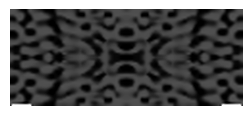

Current iteration: 43
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 7.399800687014955
Current FOM: [0.02148126]
→ Binary degree = 0.284


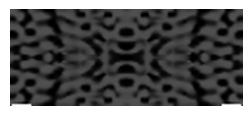

Current iteration: 44
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 7.468689408480506
Current FOM: [0.01825543]
→ Binary degree = 0.288


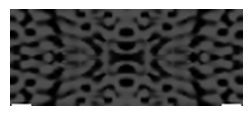

Current iteration: 45
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 7.538263715295033
Current FOM: [0.02324156]
→ Binary degree = 0.292


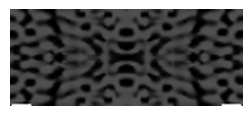

Current iteration: 46
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 7.608530363749733
Current FOM: [0.02253099]
→ Binary degree = 0.297


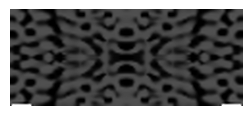

Current iteration: 47
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 7.679496174706624
Current FOM: [0.01611799]
→ Binary degree = 0.302


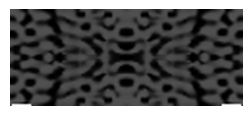

Current iteration: 48
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 7.751168034154842
Current FOM: [0.02308691]
→ Binary degree = 0.306


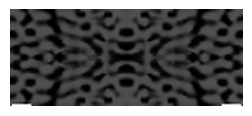

Current iteration: 49
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 7.823552893769861
Current FOM: [0.02383894]
→ Binary degree = 0.311


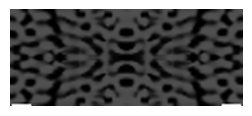

Current iteration: 50
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 7.89665777147557
Current FOM: [0.02078662]
→ Binary degree = 0.317


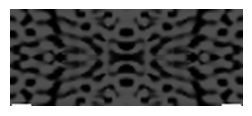

Current iteration: 51
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 7.9704897520091835
Current FOM: [0.01780287]
→ Binary degree = 0.322


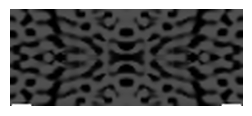

Current iteration: 52
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 8.045055987488906
Current FOM: [0.0206637]
→ Binary degree = 0.327


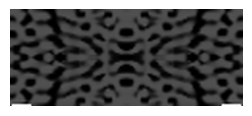

Current iteration: 53
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 8.120363697984315
Current FOM: [0.02182174]
→ Binary degree = 0.331


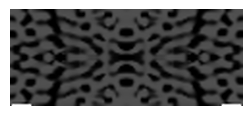

Current iteration: 54
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 8.196420172089384
Current FOM: [0.02141656]
→ Binary degree = 0.336


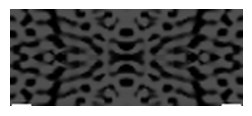

Current iteration: 55
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 8.273232767498106
Current FOM: [0.01942172]
→ Binary degree = 0.340


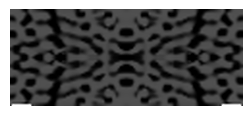

Current iteration: 56
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 8.350808911582632
Current FOM: [0.01996223]
→ Binary degree = 0.345


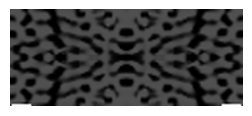

Current iteration: 57
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 8.429156101973868
Current FOM: [0.02131575]
→ Binary degree = 0.349


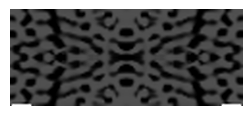

Current iteration: 58
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 8.508281907144458
Current FOM: [0.02144579]
→ Binary degree = 0.353


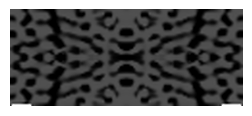

Current iteration: 59
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 8.588193966994067
Current FOM: [0.02121538]
→ Binary degree = 0.357


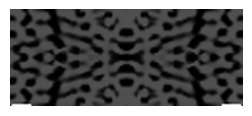

Current iteration: 60
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 8.668899993436913
Current FOM: [0.02004555]
→ Binary degree = 0.361


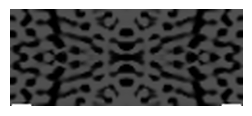

Current iteration: 61
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 8.750407770991421
Current FOM: [0.01977349]
→ Binary degree = 0.364


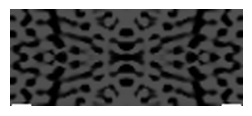

Current iteration: 62
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 8.832725157371968
Current FOM: [0.02051128]
→ Binary degree = 0.368


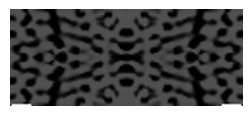

Current iteration: 63
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 8.91586008408258
Current FOM: [0.02116915]
→ Binary degree = 0.371


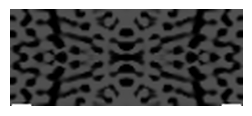

Current iteration: 64
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 8.999820557012514
Current FOM: [0.02142741]
→ Binary degree = 0.374


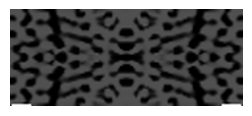

Current iteration: 65
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 9.084614657033633
Current FOM: [0.02103205]
→ Binary degree = 0.378


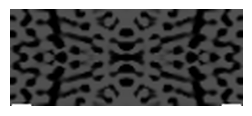

Current iteration: 66
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 9.170250540599447
Current FOM: [0.02037426]
→ Binary degree = 0.381


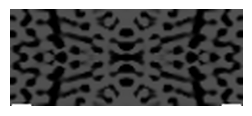

Current iteration: 67
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 9.256736440345737
Current FOM: [0.02021941]
→ Binary degree = 0.384


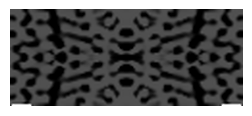

Current iteration: 68
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 9.344080665692637
Current FOM: [0.02085429]
→ Binary degree = 0.386


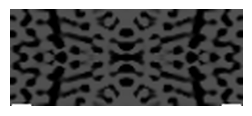

Current iteration: 69
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 9.432291603448073
Current FOM: [0.0216123]
→ Binary degree = 0.389


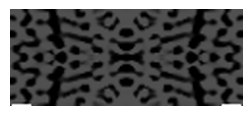

Current iteration: 70
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 9.521377718412426
Current FOM: [0.02187486]
→ Binary degree = 0.391


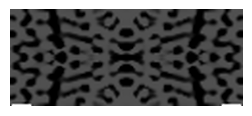

Current iteration: 71
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 9.611347553984297
Current FOM: [0.0214855]
→ Binary degree = 0.394


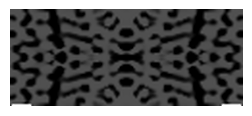

Current iteration: 72
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 9.702209732767258
Current FOM: [0.02081682]
→ Binary degree = 0.396


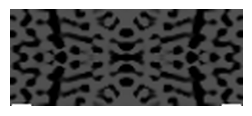

Current iteration: 73
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 9.793972957177433
Current FOM: [0.02018388]
→ Binary degree = 0.399


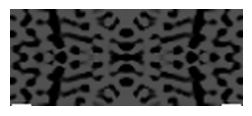

Current iteration: 74
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 9.886646010051784
Current FOM: [0.01989178]
→ Binary degree = 0.401


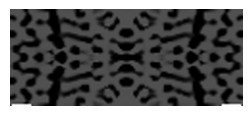

Current iteration: 75
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 9.980237755256958
Current FOM: [0.01978229]
→ Binary degree = 0.403


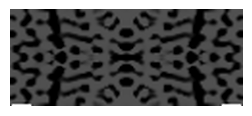

Current iteration: 76
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 10.074757138298533
Current FOM: [0.01957397]
→ Binary degree = 0.405


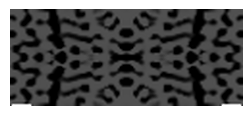

Current iteration: 77
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 10.170213186930514
Current FOM: [0.01926876]
→ Binary degree = 0.407


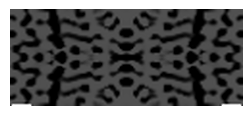

Current iteration: 78
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 10.266615011764918
Current FOM: [0.01896529]
→ Binary degree = 0.409


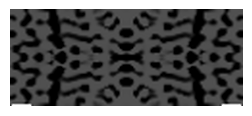

Current iteration: 79
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 10.36397180688128
Current FOM: [0.01883628]
→ Binary degree = 0.411


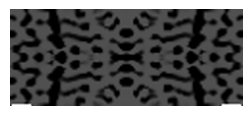

Current iteration: 80
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 10.462292850435894
Current FOM: [0.01893667]
→ Binary degree = 0.413


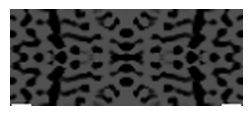

Current iteration: 81
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 10.56158750527063
Current FOM: [0.01907401]
→ Binary degree = 0.414


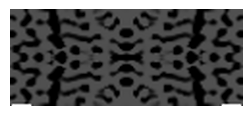

Current iteration: 82
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 10.661865219521117
Current FOM: [0.01909068]
→ Binary degree = 0.416


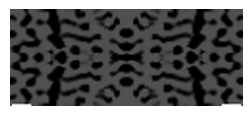

Current iteration: 83
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 10.763135527224112
Current FOM: [0.01888698]
→ Binary degree = 0.418


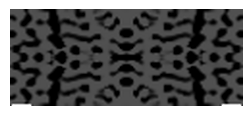

Current iteration: 84
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 10.865408048923857
Current FOM: [0.01856533]
→ Binary degree = 0.419


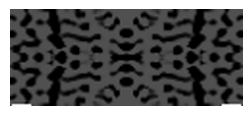

Current iteration: 85
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 10.968692492277201
Current FOM: [0.01813591]
→ Binary degree = 0.421


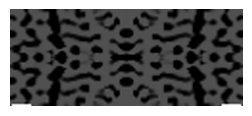

Current iteration: 86
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 11.07299865265728
Current FOM: [0.01761304]
→ Binary degree = 0.423


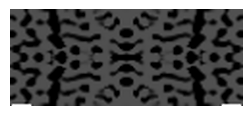

Current iteration: 87
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 11.178336413755543
Current FOM: [0.01732893]
→ Binary degree = 0.425


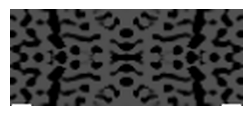

Current iteration: 88
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 11.284715748181883
Current FOM: [0.01747852]
→ Binary degree = 0.427


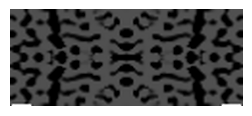

Current iteration: 89
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 11.392146718062623
Current FOM: [0.01752509]
→ Binary degree = 0.429


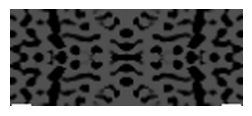

Current iteration: 90
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 11.500639475636145
Current FOM: [0.01712265]
→ Binary degree = 0.432


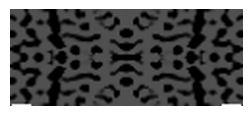

Current iteration: 91
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 11.610204263845876
Current FOM: [0.0167644]
→ Binary degree = 0.434


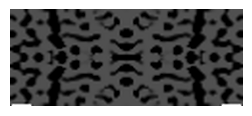

Current iteration: 92
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 11.72085141693038
Current FOM: [0.01688016]
→ Binary degree = 0.436


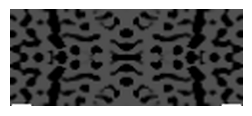

Current iteration: 93
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 11.832591361010289
Current FOM: [0.01721912]
→ Binary degree = 0.439


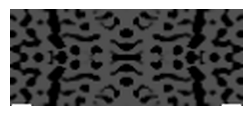

Current iteration: 94
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 11.945434614671798
Current FOM: [0.01749575]
→ Binary degree = 0.441


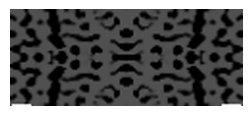

Current iteration: 95
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 12.059391789546414
Current FOM: [0.01773606]
→ Binary degree = 0.444


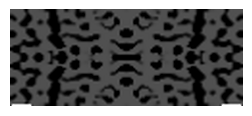

Current iteration: 96
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 12.174473590886675
Current FOM: [0.01803357]
→ Binary degree = 0.446


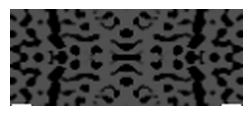

Current iteration: 97
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 12.290690818137545
Current FOM: [0.01836309]
→ Binary degree = 0.449


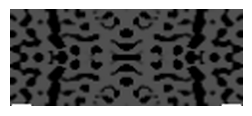

Current iteration: 98
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 12.408054365503139
Current FOM: [0.01846178]
→ Binary degree = 0.451


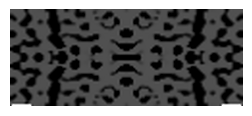

Current iteration: 99
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 12.526575222508468
Current FOM: [0.01811036]
→ Binary degree = 0.454


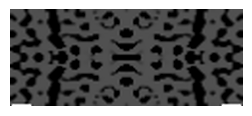

Current iteration: 100
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 12.646264474555874
Current FOM: [0.01729262]
→ Binary degree = 0.457


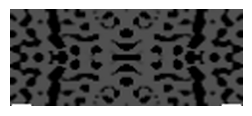

Current iteration: 101
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 12.767133303475784
Current FOM: [0.0163115]
→ Binary degree = 0.459


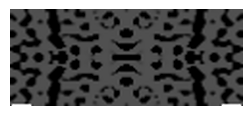

Current iteration: 102
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 12.889192988071448
Current FOM: [0.0156727]
→ Binary degree = 0.462


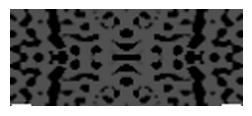

Current iteration: 103
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 13.012454904657277
Current FOM: [0.01552031]
→ Binary degree = 0.465


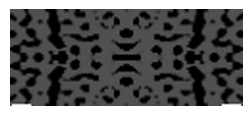

Current iteration: 104
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 13.136930527590414
Current FOM: [0.01563527]
→ Binary degree = 0.468


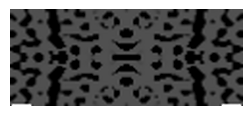

Current iteration: 105
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 13.262631429795123
Current FOM: [0.01574762]
→ Binary degree = 0.470


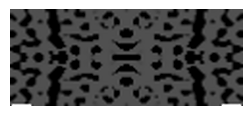

Current iteration: 106
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 13.389569283279629
Current FOM: [0.0157662]
→ Binary degree = 0.473


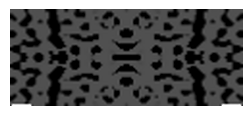

Current iteration: 107
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 13.517755859644955
Current FOM: [0.01580651]
→ Binary degree = 0.475


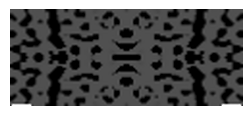

Current iteration: 108
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 13.647203030585361
Current FOM: [0.01599689]
→ Binary degree = 0.478


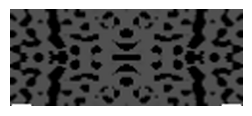

Current iteration: 109
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 13.777922768379925
Current FOM: [0.01630204]
→ Binary degree = 0.480


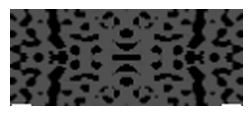

Current iteration: 110
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 13.909927146374821
Current FOM: [0.01654813]
→ Binary degree = 0.482


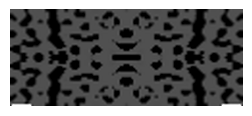

Current iteration: 111
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 14.043228339455835
Current FOM: [0.01665239]
→ Binary degree = 0.484


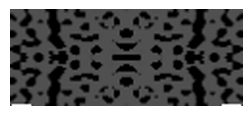

Current iteration: 112
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 14.177838624510631
Current FOM: [0.01663785]
→ Binary degree = 0.486


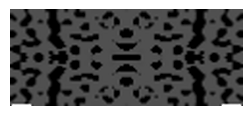

Current iteration: 113
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 14.313770380880282
Current FOM: [0.01654814]
→ Binary degree = 0.488


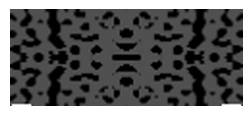

Current iteration: 114
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 14.451036090799557
Current FOM: [0.01643665]
→ Binary degree = 0.490


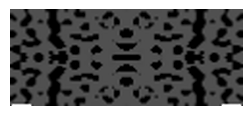

Current iteration: 115
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 14.58964833982545
Current FOM: [0.01640828]
→ Binary degree = 0.492


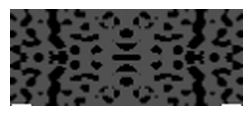

Current iteration: 116
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 14.729619817253424
Current FOM: [0.01666913]
→ Binary degree = 0.494


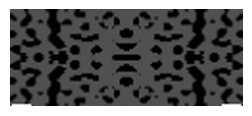

Current iteration: 117
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 14.870963316520792
Current FOM: [0.01719625]
→ Binary degree = 0.495


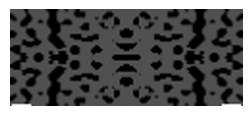

Current iteration: 118
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 15.013691735596723
Current FOM: [0.0175785]
→ Binary degree = 0.497


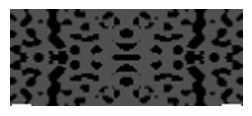

Current iteration: 119
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 15.15781807735825
Current FOM: [0.01762104]
→ Binary degree = 0.499


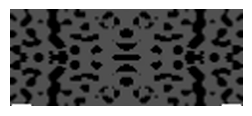

Current iteration: 120
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 15.303355449951715
Current FOM: [0.01736512]
→ Binary degree = 0.500


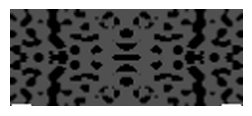

Current iteration: 121
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 15.450317067139029
Current FOM: [0.01701585]
→ Binary degree = 0.502


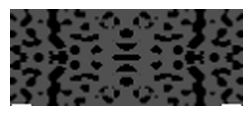

Current iteration: 122
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 15.59871624862814
Current FOM: [0.01688738]
→ Binary degree = 0.503


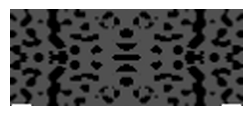

Current iteration: 123
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 15.748566420387053
Current FOM: [0.01698764]
→ Binary degree = 0.504


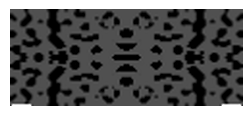

Current iteration: 124
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 15.899881114940758
Current FOM: [0.01708625]
→ Binary degree = 0.505


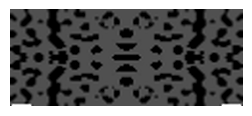

Current iteration: 125
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 16.052673971650385
Current FOM: [0.01705939]
→ Binary degree = 0.506


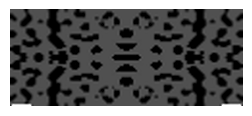

Current iteration: 126
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 16.206958736973913
Current FOM: [0.01699493]
→ Binary degree = 0.507


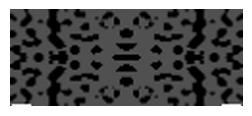

Current iteration: 127
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 16.362749264707706
Current FOM: [0.01709014]
→ Binary degree = 0.508


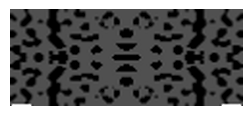

Current iteration: 128
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 16.520059516208175
Current FOM: [0.0172889]
→ Binary degree = 0.509


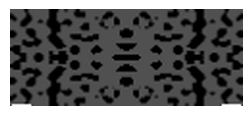

Current iteration: 129
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 16.678903560592815
Current FOM: [0.01741464]
→ Binary degree = 0.510


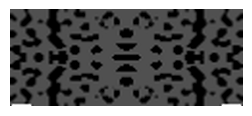

Current iteration: 130
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 16.839295574919866
Current FOM: [0.01744881]
→ Binary degree = 0.511


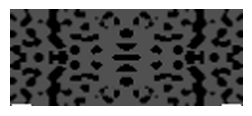

Current iteration: 131
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 17.001249844345807
Current FOM: [0.01744457]
→ Binary degree = 0.512


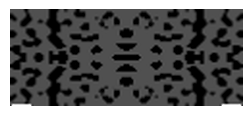

Current iteration: 132
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 17.164780762259912
Current FOM: [0.01746244]
→ Binary degree = 0.513


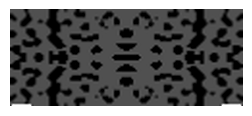

Current iteration: 133
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 17.32990283039505
Current FOM: [0.01749818]
→ Binary degree = 0.513


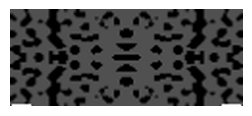

Current iteration: 134
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 17.496630658913883
Current FOM: [0.01743026]
→ Binary degree = 0.514


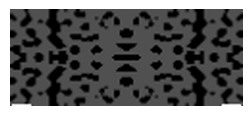

Current iteration: 135
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 17.66497896646965
Current FOM: [0.01707982]
→ Binary degree = 0.515


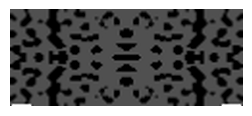

Current iteration: 136
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 17.83496258024062
Current FOM: [0.016498]
→ Binary degree = 0.515


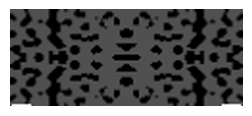

Current iteration: 137
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 18.006596435937386
Current FOM: [0.01614734]
→ Binary degree = 0.516


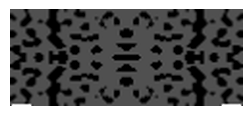

Current iteration: 138
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 18.179895577782034
Current FOM: [0.01607263]
→ Binary degree = 0.517


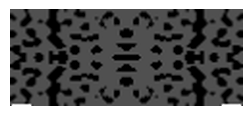

Current iteration: 139
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 18.35487515845833
Current FOM: [0.01619836]
→ Binary degree = 0.517


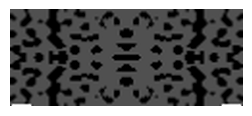

Current iteration: 140
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 18.53155043903192
Current FOM: [0.01645333]
→ Binary degree = 0.518


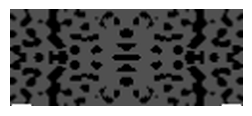

Current iteration: 141
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 18.709936788839617
Current FOM: [0.01660523]
→ Binary degree = 0.518


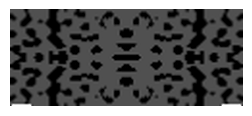

Current iteration: 142
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 18.890049685346792
Current FOM: [0.01651869]
→ Binary degree = 0.519


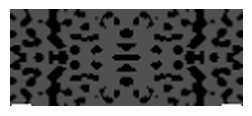

Current iteration: 143
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 19.07190471397185
Current FOM: [0.0163423]
→ Binary degree = 0.520


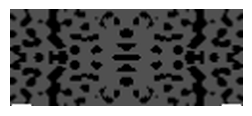

Current iteration: 144
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 19.255517567876794
Current FOM: [0.01631055]
→ Binary degree = 0.520


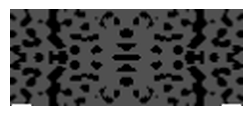

Current iteration: 145
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 19.440904047722803
Current FOM: [0.0165095]
→ Binary degree = 0.520


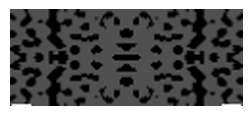

Current iteration: 146
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 19.62808006138982
Current FOM: [0.0168467]
→ Binary degree = 0.521


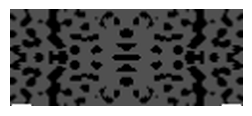

Current iteration: 147
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 19.817061623658994
Current FOM: [0.01709815]
→ Binary degree = 0.521


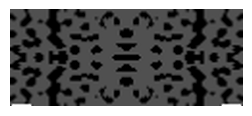

Current iteration: 148
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 20.00786485585696
Current FOM: [0.01706636]
→ Binary degree = 0.522


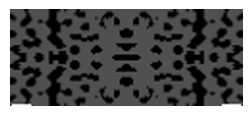

Current iteration: 149
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 20.20050598546077
Current FOM: [0.01684338]
→ Binary degree = 0.522


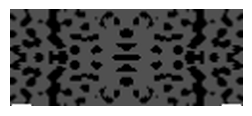

Current iteration: 150
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current beta: 20.395001345662386
Current FOM: [0.01667497]
→ Binary degree = 0.523


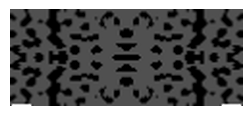

In [355]:
cur_beta=5
n=Nx*Ny
x=np.ones(n)*0.5
x_history = []

Max_iter = 150
gradient = x*0

while cur_iter[0] < Max_iter:
    # 1) 한 번 실행
    x, adam_m, adam_v, cur_beta = f(x,eta_i,cur_beta)
    # 2) 전체 Geo (=mapping 결과) 가져오기
    Geo = mapping(x, cur_beta, eta_i)  # shape = (Nx*Ny,)

    # 3) binarization index 계산
    # Bi_idx = np.sum(np.where(((1e-3 < Geo) & (Geo < (1 - 1e-3))), 0, 1)) / Geo.size

    # 4) 임계치 도달 시 마지막 binary 실행 후 루프 종료
    if binarization_history[cur_iter[0]-1] > 0.95:
        print("Binarization threshold reached. Final binary mapping")
        # beta = inf으로 하여 완전 0/1 투영
        # x, adam_m, adam_v, _ = f(x, eta_i, np.inf)
        break

0.5225061198552622

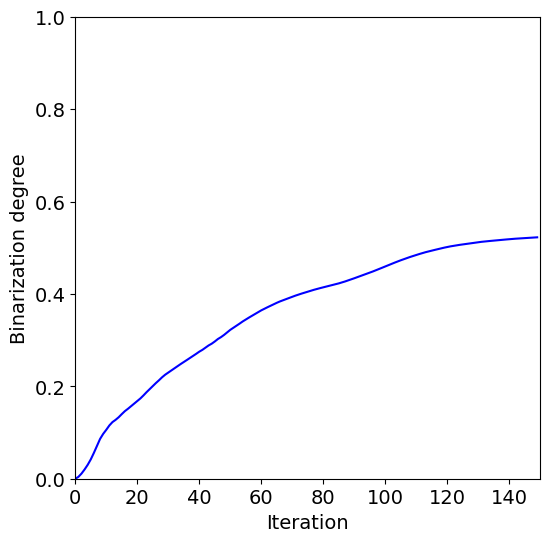

In [356]:
plt.figure(figsize = (6,6))
plt.plot(binarization_history, 'b-')
plt.xlabel('Iteration',fontsize = 14)
plt.ylabel('Binarization degree',fontsize = 14)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.xlim(0, np.array(cur_iter))
plt.ylim(0,1)

max(binarization_history)

In [385]:
# 1) 배열로 변환
eval_hist = np.array(evaluation_history)

# 2) 최대값과 그 인덱스 찾기 (0-based)
max_val   = eval_hist.max()
max_idx0  = eval_hist.argmax()

# 3) 사람이 셀 때 보통 1부터 시작하니 +1
iteration = max_idx0 + 1

print(f"최대 FoM = {max_val:.6f} 는 iteration {iteration} 에서 나왔습니다.")

최대 FoM = 0.023839 는 iteration 49 에서 나왔습니다.


20.395001345662386

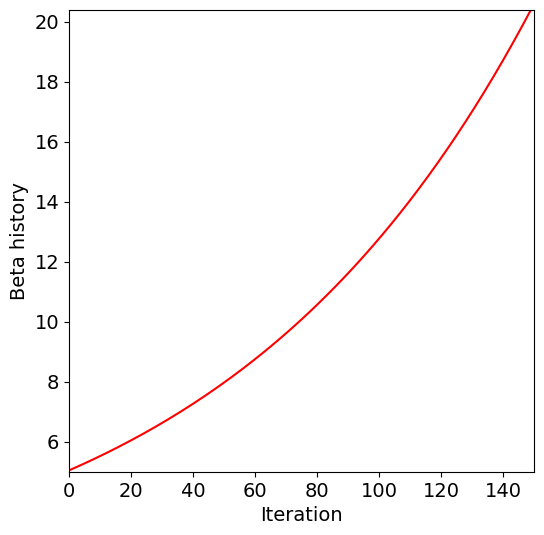

In [363]:
plt.figure(figsize = (6,6))
plt.plot(beta_history, 'r-')
plt.xlabel('Iteration',fontsize = 14)
plt.ylabel('Beta history',fontsize = 14)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.xlim(0, np.array(cur_iter))
plt.ylim(5,max(beta_history))

max(beta_history)

In [18]:
foms = np.real(evaluation_history)
best_idx = np.argmax(foms)

init_idx = 4  # 0-based index → 5번째
if len(foms) > init_idx:
    init_fom    = foms[init_idx]
    init_beta   = beta_history[init_idx]
    init_design = x_history[init_idx]
    print(f"[Iteration 5] FoM = {init_fom:.4e}, β = {init_beta:.4f}, 디자인 (첫 10개) = {init_design[:10]} …")
else:
    print(f"Iteration 수({len(foms)})가 5보다 작아 5번째 정보가 없습니다.")

# --- 2) FoM 최대일 때 정보 ---
best_fom    = foms[best_idx]
best_beta   = beta_history[best_idx]
best_design = x_history[best_idx]
print(f"[Best Iteration {best_idx+1}] FoM = {best_fom:.4e}, β = {best_beta:.4f}, 디자인 (첫 10개) = {best_design[:10]} …")

# --- 3) 마지막 iteration 정보 ---
last_idx    = len(foms) - 1
last_fom    = foms[last_idx]
last_beta   = beta_history[last_idx]
last_design = x_history[last_idx]
print(f"[Last Iteration {last_idx+1}] FoM = {last_fom:.4e}, β = {last_beta:.4f}, 디자인 (첫 10개) = {last_design[:10]} …")


IndexError: list index out of range

# FOM이 떨어지는 지점에서 beta 값이 수정되는건지?
# Multi layer 

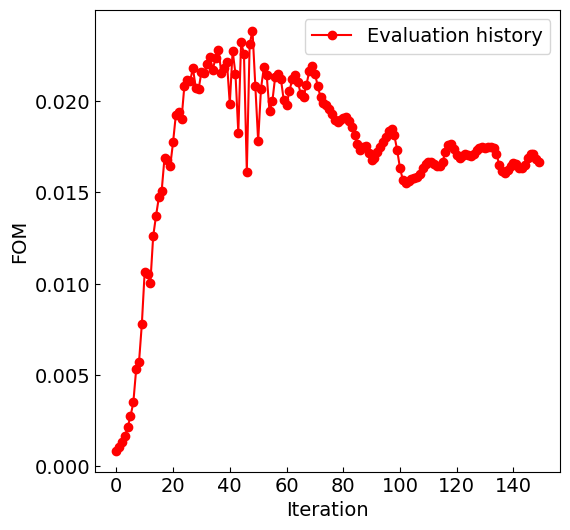

In [357]:
plt.figure(figsize = (6,6))

plt.plot(evaluation_history, 'or-',   label='Evaluation history',)

plt.xlabel('Iteration',fontsize = 14)
plt.ylabel('FOM',fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

# plt.title('Optimization', fontsize = 16)
plt.tick_params(direction = 'in')

plt.legend( fontsize = 14,)

plt.show()

In [374]:
import numpy as np

# 1) 배열로 변환
eval_hist = np.array(evaluation_history)

# 2) 최대값과 그 인덱스 찾기 (0-based)
max_val   = eval_hist.max()
max_idx0  = eval_hist.argmax()

# 3) 사람이 셀 때 보통 1부터 시작하니 +1
iteration = max_idx0 + 1

print(f"최대 FoM = {max_val:.6f} 는 iteration {iteration} 에서 나왔습니다.")


최대 FoM = 0.023839 는 iteration 49 에서 나왔습니다.


In [ ]:
# np.savetxt("init_design.txt", x_history[init_idx])
# np.savetxt("best_design.txt", x_history[best_idx])
# np.savetxt("last_design.txt", x_history[last_idx])

In [ ]:
# np.savetxt("adam_weights_2lambda_pos_mean_objf.txt", design_variables.weights)

In [ ]:
# np.savetxt("adam_weights_2lambda_pos_new_objf.txt", design_variables.weights)

In [ ]:
# np.savetxt("adam_weights_1lambda_pos_new_objf.txt", design_variables.weights)

In [ ]:
# np.savetxt("adam_weights_2lambda_pos.txt", design_variables.weights)

In [10]:
import numpy as np

data = np.loadtxt('adam_weights_1lambda_pos_new_objf.txt')

print("Loaded array shape:", data.shape)

opt.update_design([data])
# data


Loaded array shape: (6171,)


In [405]:
data_init = np.loadtxt('init_design.txt')
data_best = np.loadtxt('best_design.txt')
data_last = np.loadtxt('last_design.txt')

# opt.update_design([data_init])
# opt.update_design([data_best])
opt.update_design([data_last])

In [ ]:
# np.savetxt("adam_iter400.txt", design_variables.weights)

In [267]:
iter_400 = np.loadtxt('adam_iter400.txt')
opt.update_design([iter_400])

In [61]:
# np.savetxt("second.txt", design_variables.weights)
second = np.loadtxt('second.txt')
opt.update_design([second])

In [ ]:
# k = design_variables.weights

In [375]:
opt.update_design([k])

(-1.2, 1.2, 1.0, 2.0)

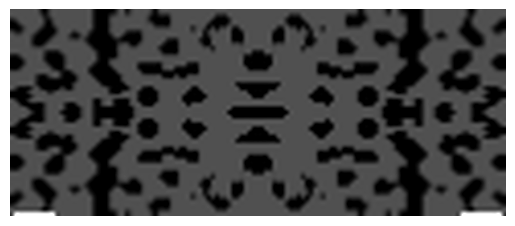

In [376]:
opt.plot2D(
    output_plane = mp.Volume(size = design_region.size, center = design_region.center),
    
    show_sources=False,
    show_monitors=False,
    show_boundary_layers=False,
)
plt.axis(False)

<Axes: xlabel='X', ylabel='Y'>

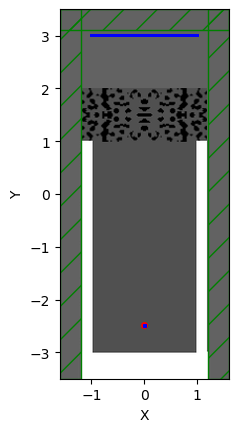

In [377]:
offset = 0.01
flux_size = 0.02
mn_size = 2

monitor_position_y, monitor_size = mp.Vector3(0, center_y_monitor_position), mp.Vector3(mn_size,0)

#### input source의 flux ####
input_flux = opt.sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=sources.center - mp.Vector3(offset, 0, 0),
                    size=mp.Vector3(0, flux_size),
                    # direction=mp.X, 
                    weight=-1),
        mp.FluxRegion(center=sources.center + mp.Vector3(offset, 0, 0),
                    size=mp.Vector3(0, flux_size),
                    # direction=mp.X
                    ),
        mp.FluxRegion(center=sources.center - mp.Vector3(0, offset, 0),
                    size=mp.Vector3(flux_size, 0),
                    # direction=mp.Y, 
                    weight=-1),
        mp.FluxRegion(center=sources.center + mp.Vector3(0, offset, 0),
                    size=mp.Vector3(flux_size, 0),
                    # direction=mp.Y
                    )
    )

#### output flux -> add flux로 계산한 poynting vector ####
out_flux = opt.sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(
                center=monitor_position_y,
                size=monitor_size,
                # direction=mp.Y
                # weight=-1
        )
    )

#### output flux -> 성분별 field를 뽑고, poynting vector를 계산할 예정 ####
dft_fields = opt.sim.add_dft_fields([mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz], fcen, 0, 1, 
                                    center = monitor_position_y,
                                    size = monitor_size, 
                                    yee_grid=True)

opt.sim.plot2D()


/home/min/miniconda3/envs/mp/lib/python3.9/site-packages/meep/visualization.py:284: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


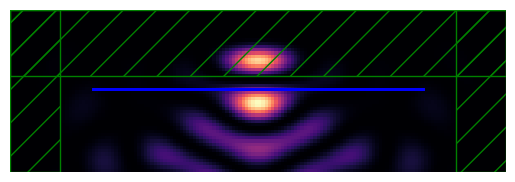

In [378]:
# opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10/df, mp.Ez, sources.center, 1e-3))
sim.run(until_after_sources=mp.stop_when_fields_decayed(10/df, mp.Ez, sources.center, 1e-3))

opt.sim.plot2D(
    fields=mp.Ez,
    output_plane=mp.Volume(
    center = monitor_position_y,
    size = mp.Vector3(3, 1)),
    field_parameters={
        'post_process': lambda x: np.abs(np.real(x))**2,  # 복소수 필드 x → intensity |x|^2
        'cmap': 'magma',                         # 원하시는 colormap
        'alpha': 1,                            # 투명도
        'interpolation': 'none'
    },
    eps_parameters={'cmap':'magma','alpha':0.5}
)
plt.axis(False)
plt.show()

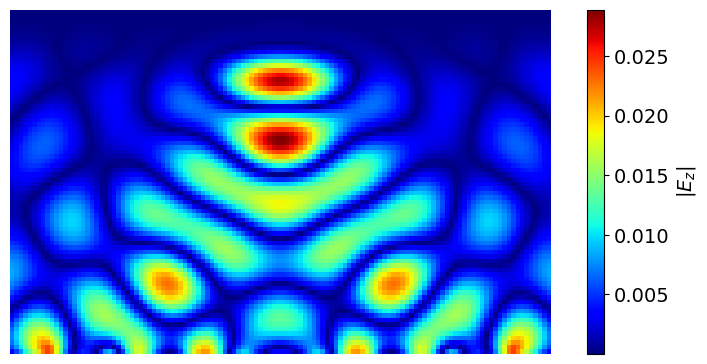

In [379]:
import numpy as np
import matplotlib.pyplot as plt
import meep as mp

nx = int(design_region_resolution * design_region_width) + 1
x_res = np.linspace(-design_region_width/2,
                     design_region_width/2,
                     nx)

y_start = center_y_design + design_region_height/2
y_end   = center_y_monitor_position + 1/fcen
ny = int(design_region_resolution * (y_end - y_start)) + 1
y_res = np.linspace(y_start, y_end, ny)

vol = mp.Volume(
    center=mp.Vector3(0, (y_start + y_end)/2, 0),
    size=  mp.Vector3(design_region_width,
                      y_end - y_start,
                      0)
)
Ez_slice = opt.sim.get_array(mp.Ez, vol).T   # shape == (ny, nx)

plt.figure(figsize=(8,4))
plt.imshow(
    np.abs(Ez_slice),      # (ny, nx)
    origin='lower',
    extent=[x_res.min(), x_res.max(), y_res.min(), y_res.max()],
    aspect='equal',
    cmap='jet'
)

cbar = plt.colorbar()
cbar.set_label(r'$|E_z|$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
# plt.ylabel('Height $y$ (µm)',           fontsize=14)
# plt.title(r'Monitor size: $2\ \mu m$',   fontsize=16)

# 틱 폰트 크기 및 방향 맞추기
plt.tick_params(direction='in', labelsize=14)
plt.tight_layout()
plt.axis('off')
plt.show()

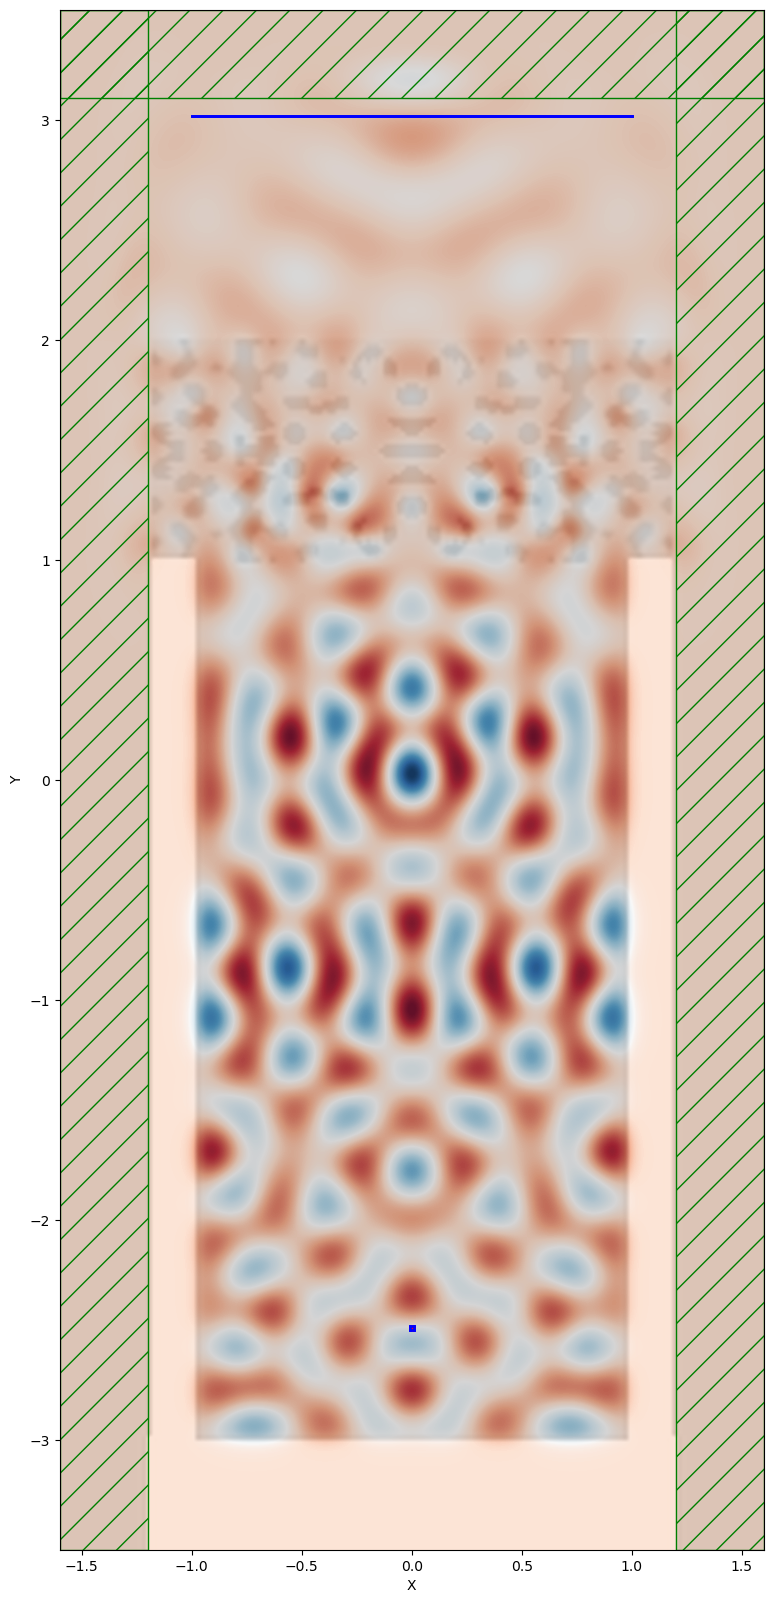

In [380]:
plt.figure(figsize=(10, 20))
opt.sim.plot2D(fields = mp.Ez,
    #            show_sources=True,
    # show_monitors=True,
    # show_boundary_layers=True,
    #        field_parameters={
    #     'cmap': 'magma',    # magma 컬러맵 지정
    #     'alpha': 0.5,       # 필드 투명도 (0.0~1.0)
    #     'interpolation': 'none'
    # }
)

plt.show()

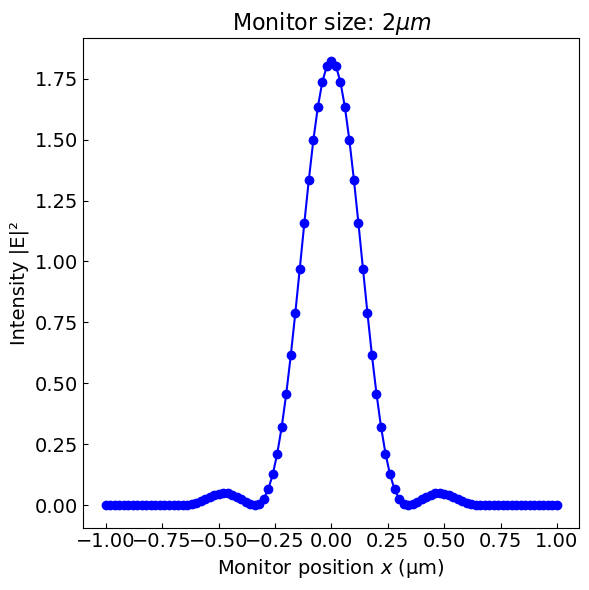

In [381]:
external_field_array = np.real(opt.sim.get_dft_array(dft_fields, mp.Ez, 0))

N = len(external_field_array)
W = mn_size                           # μm 단위 모니터 폭
x = np.linspace(-W/2, W/2, N)                     # μm 단위 위치
z = abs(center_y_monitor_position - center_y_source_position)  # μm 단위 거리

# 3) Intensity 계산
I = np.abs(external_field_array)**2

# 4) θ 축으로 플롯
plt.figure(figsize=(6,6))
plt.plot(x, I, 'bo-')


plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
plt.ylabel('Intensity |E|²',       fontsize=14)
# plt.ylabel('phase',       fontsize=14)
plt.title(r'Monitor size: $2\mu m$', fontsize=16)
plt.tick_params(direction = 'in')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tight_layout()
plt.show()

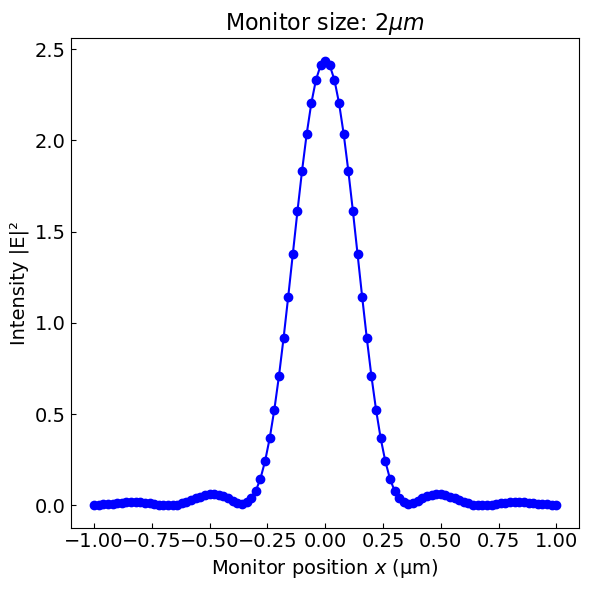

In [382]:
external_field_array = np.abs(opt.sim.get_dft_array(dft_fields, mp.Ez, 0))

N = len(external_field_array)
W = mn_size                           # μm 단위 모니터 폭
x = np.linspace(-W/2, W/2, N)                     # μm 단위 위치
z = abs(center_y_monitor_position - center_y_source_position)  # μm 단위 거리

# 3) Intensity 계산
I = np.abs(external_field_array)**2

# 4) θ 축으로 플롯
plt.figure(figsize=(6,6))
plt.plot(x, I, 'bo-')


plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
plt.ylabel('Intensity |E|²',       fontsize=14)
# plt.ylabel('phase',       fontsize=14)
plt.title(r'Monitor size: $2\mu m$', fontsize=16)
plt.tick_params(direction = 'in')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tight_layout()
plt.show()

In [335]:
import numpy as np

I = np.abs(external_field_array)**2
N = len(I)
W = mn_size
x = np.linspace(-W/2, W/2, N)
z = abs(center_y_monitor_position - center_y_source_position)

center_idx = np.argmax(I)
# 간단히 for문으로
for i in range(center_idx+1, N-1):
    if I[i] < I[i-1] and I[i] < I[i+1]:
        x_limit = abs(x[i])
        break
else:
    raise RuntimeError("1차 링 경계를 찾을 수 없음")

x_min, x_max = -x_limit, x_limit

mask = (x >= x_min) & (x <= x_max)

x_slice = x[mask]
I_slice = I[mask]

dx = x[1] - x[0]
flux_slice = np.sum(I_slice) * dx   

input = np.array(mp.get_fluxes(input_flux))[0]
output = np.array(mp.get_fluxes(out_flux))[0]

print("Input flux :", input)
print("Output flux :", output)
print(f"±{x_limit:.3f} µm 구간 integrated intensity: {flux_slice}")

optical_eqe = flux_slice/input * 100
print("1차 ring까지의 Optical EQE :", optical_eqe,"%")

Input flux : 0.533379165473088
Output flux : 0.7148995657662376
±0.360 µm 구간 integrated intensity: 0.4301442141406232
1차 ring까지의 Optical EQE : 80.64510989271598 %


In [336]:
eqe = mp.get_fluxes(out_flux)[0]/mp.get_fluxes(input_flux)[0]*100

print("Input flux :", mp.get_fluxes(input_flux)[0])
print("Output flux :", mp.get_fluxes(out_flux)[0])
print("EQE(%) :", eqe,"%")

Input flux : 0.533379165473088
Output flux : 0.7148995657662376
EQE(%) : 134.03215049319513 %
